In [1]:
!pip install -U statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 22.1 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
df1 = pd.read_csv('/content/BTC-USD.csv', index_col='Date', parse_dates=True)

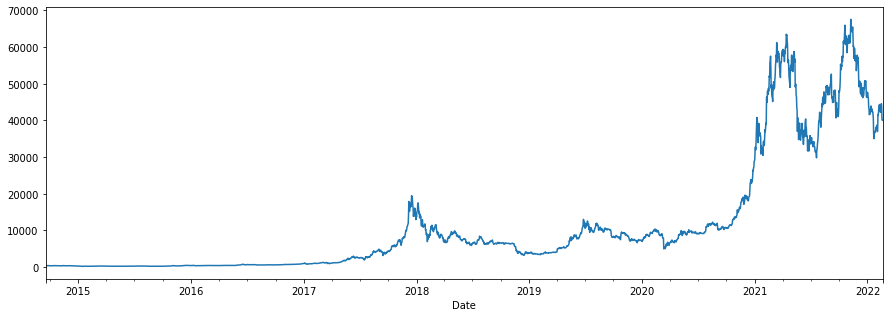

In [4]:
df = df1[['Close','Volume']].copy().dropna()
df['Close'].plot(figsize=(15, 5))


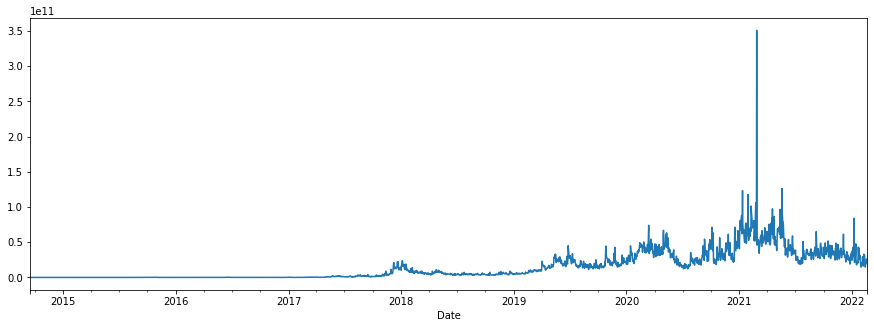

In [5]:
df['Volume'].plot(figsize=(15, 5))

In [6]:
df.head()

,Close,Volume
Date,,
2014-09-17,457.334015,21056800
2014-09-18,424.440002,34483200
2014-09-19,394.795990,37919700
2014-09-20,408.903992,36863600
2014-09-21,398.821014,26580100


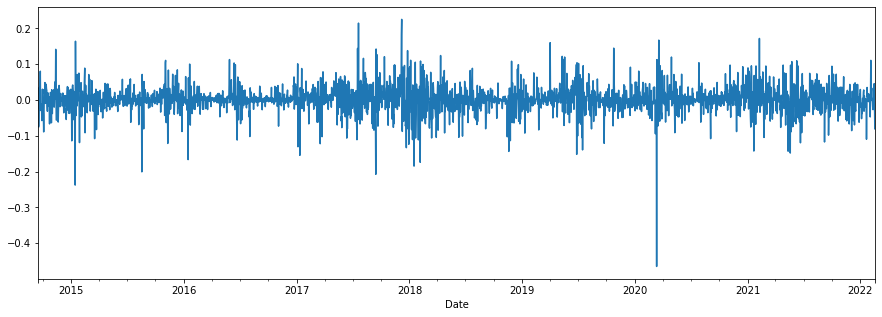

In [7]:
df['Closelogdf'] = np.log(df['Close']).diff()
df['Closelogdf'].plot(figsize=(15, 5))

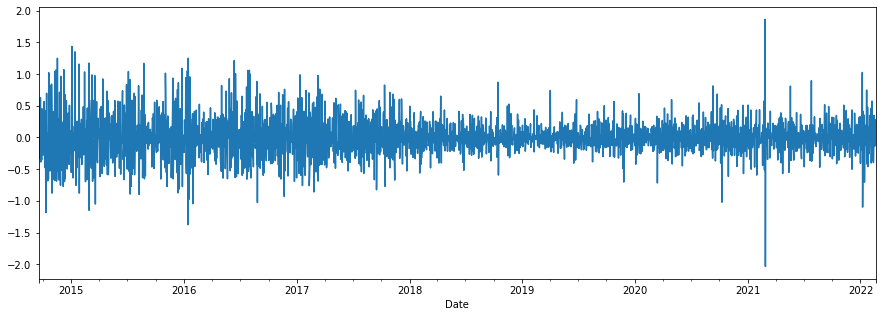

In [8]:
df['Volumelogdf'] = np.log(df['Volume']).diff()
df['Volumelogdf'].plot(figsize=(15, 5))

In [9]:
cols = ['Closelogdf', 'Volumelogdf']

In [10]:
df1 = df.iloc[1:][cols].copy()

In [11]:
Ntest = 10
train = df1.iloc[:-Ntest].copy()
test = df1.iloc[-Ntest:].copy()

In [12]:
train_idx = df1.index <= train.index[-1]
test_idx = ~train_idx

In [13]:
# just overwrite originals, unless you want to preserve them
scaler = StandardScaler()
train[cols] = scaler.fit_transform(train)
test[cols] = scaler.transform(test)

In [14]:
df1.loc[train_idx, :] = train
df1.loc[test_idx, :] = test

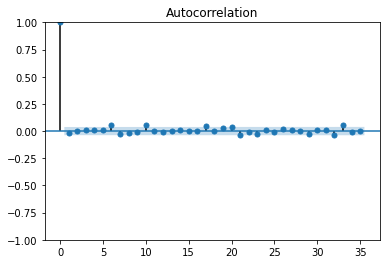

In [15]:
plot_acf(train['Closelogdf']);

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


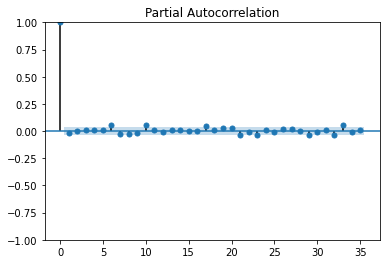

In [16]:
plot_pacf(train['Closelogdf']);

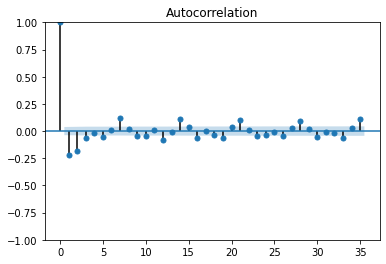

In [17]:
plot_acf(train['Volumelogdf']);

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


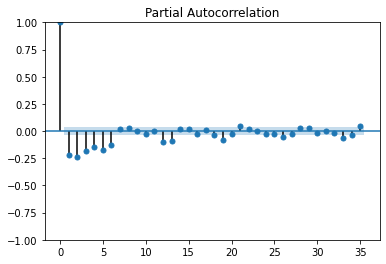

In [18]:
plot_pacf(train['Volumelogdf']);

In [19]:
adfuller(train['Closelogdf'])

(-15.607243342899958,
 1.7982832230519252e-28,
 9,
 2692,
 {'1%': -3.4327814808594526,
  '5%': -2.8626142490094613,
  '10%': -2.5673418586412},
 7584.383952440698)

In [20]:
adfuller(train['Volumelogdf'])

(-12.46025134091296,
 3.418648639309753e-23,
 27,
 2674,
 {'1%': -3.4327978640972296,
  '5%': -2.8626214842914908,
  '10%': -2.5673457107278095},
 6951.277359759953)

In [21]:
p = 10
q = 10

In [22]:
t0 = datetime.now()
model = VARMAX(train, order=(p, q))
res = model.fit(maxiter=100)
print("Duration:", datetime.now() - t0)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:11:54.733444


In [23]:
fcast = res.get_forecast(Ntest)

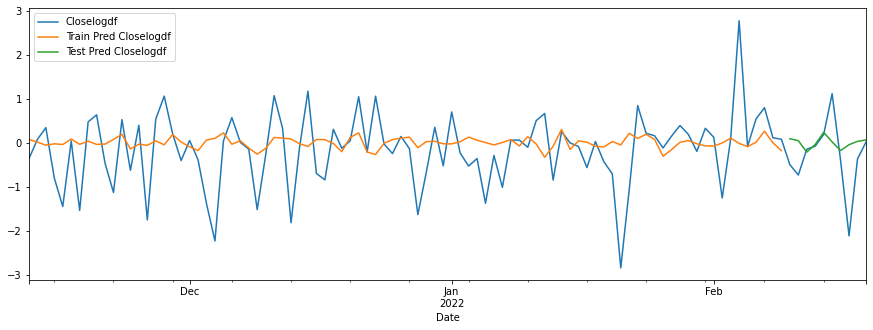

In [24]:
df1.loc[train_idx, 'Train Pred Closelogdf'] = res.fittedvalues['Closelogdf']
df1.loc[test_idx, 'Test Pred Closelogdf'] = fcast.predicted_mean['Closelogdf']
plot_cols = ['Closelogdf', 'Train Pred Closelogdf', 'Test Pred Closelogdf']
df1.iloc[-100:][plot_cols].plot(figsize=(15, 5));

Text(0.5, 1.0, 'varma model Train R^2: 0.356,Test R^2: 0.0.460 ')

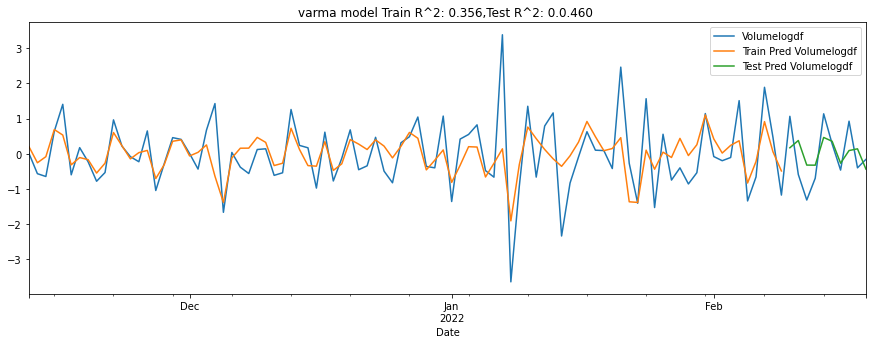

In [25]:
df1.loc[train_idx, 'Train Pred Volumelogdf'] = res.fittedvalues['Volumelogdf']
df1.loc[test_idx, 'Test Pred Volumelogdf'] = fcast.predicted_mean['Volumelogdf']
plot_cols = ['Volumelogdf', 'Train Pred Volumelogdf', 'Test Pred Volumelogdf']
df1.iloc[-100:][plot_cols].plot(figsize=(15, 5));
plt.title('varma model Train R^2: 0.356,Test R^2: 0.0.460 ')

In [26]:
for col in cols:
  y_true = df1.loc[train_idx, col]
  y_pred = res.fittedvalues[col]
  print("Train R^2:", r2_score(y_true, y_pred))

  y_true = df1.loc[test_idx, col]
  y_pred = fcast.predicted_mean[col]
  print("Test R^2:", r2_score(y_true, y_pred))

Train R^2: 0.014654422016302848
Test R^2: -0.12151742253038145
Train R^2: 0.2568643893531466
Test R^2: 0.3001549917660894


## ARIMA Baseline

In [27]:
for col in cols:
  model = ARIMA(train[col], order=(p, 0, q))
  res = model.fit()
  fcast = res.get_forecast(Ntest)
  y_train = df1.loc[train_idx, col]
  y_test = df1.loc[test_idx, col]
  print(f"{col} Train R^2:", r2_score(y_train, res.fittedvalues))
  print(f"{col} Test R^2:", r2_score(y_test, fcast.predicted_mean))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Closelogdf Train R^2: 0.016075299555746936
Closelogdf Test R^2: -0.21053731089732874


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Volumelogdf Train R^2: 0.22696986366684357
Volumelogdf Test R^2: 0.3602189474162143


Text(0.5, 1.0, 'arima model Train R^2: 0.226 Test R^2: 0.300 ')

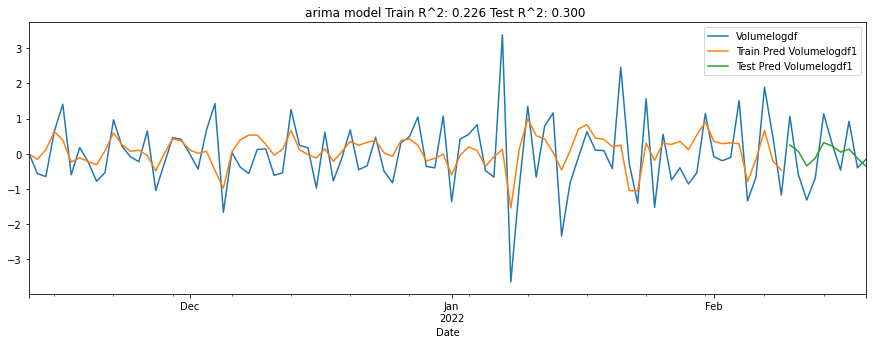

In [28]:
df1.loc[train_idx, 'Train Pred Volumelogdf1'] = res.fittedvalues
df1.loc[test_idx, 'Test Pred Volumelogdf1'] = fcast.predicted_mean
plot_cols = ['Volumelogdf', 'Train Pred Volumelogdf1', 'Test Pred Volumelogdf1']
df1.iloc[-100:][plot_cols].plot(figsize=(15, 5));
plt.title('arima model Train R^2: 0.226 Test R^2: 0.300 ')